# Experiments for master's thesis


In [1]:
from typing import Tuple, Callable
import torchvision
import numpy
import torch
from lrp import norm, image

# Normalization
norm_fn: Callable[[torch.Tensor], torch.Tensor] = norm.ILSVRC2012_BatchNorm()

# Input data
img: numpy.array = image.load_normalized_img('../castle.jpg')
X: torch.Tensor = norm_fn(image.img_to_tensor(img))

# Model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = norm_fn(torch.zeros(*shape))
high: torch.Tensor = norm_fn(torch.ones(*shape))


## Hyperparameter Grid Search

In [2]:
from lrp.rules import LrpZBoxRule, LrpGammaRule, LrpEpsilonRule, LrpZeroRule

from typing import List, Dict, Union, Tuple
from lrp.filter import LayerFilter
from lrp.zennit.types import AvgPool, Linear
import lrp.rules as rules

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

### Gamma Rule

Create a grid search for the gamma rule.

In [3]:
import pickle

# Load cached results
with open('results.pickle', 'rb') as f:
  results = pickle.load(f)

In [4]:
%%script false --no-raise-error

from lrp.core import LRP
gammas: numpy.ndarray = numpy.linspace(0.0, 1.0, num=20)

# Save gamma values to file
numpy.savetxt(fname='gammas.csv', X=gammas, newline=',')

# Rule-Layer Mapping
name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': None}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

results: List[Tuple[float, torch.Tensor]] = [None]*len(gammas)
for i, gamma in enumerate(gammas):
    # Set gamma hyperparameter
    name_map[1][2]['gamma'] = gamma

    lrp = LRP(model)
    lrp.convert_layers(name_map)
    R: torch.Tensor = lrp.relevance(X)
    results[i] = (gamma, R)

# Cache results
with open("results.pickle", "wb") as f:
    pickle.dump(results, f)

### Grid plot

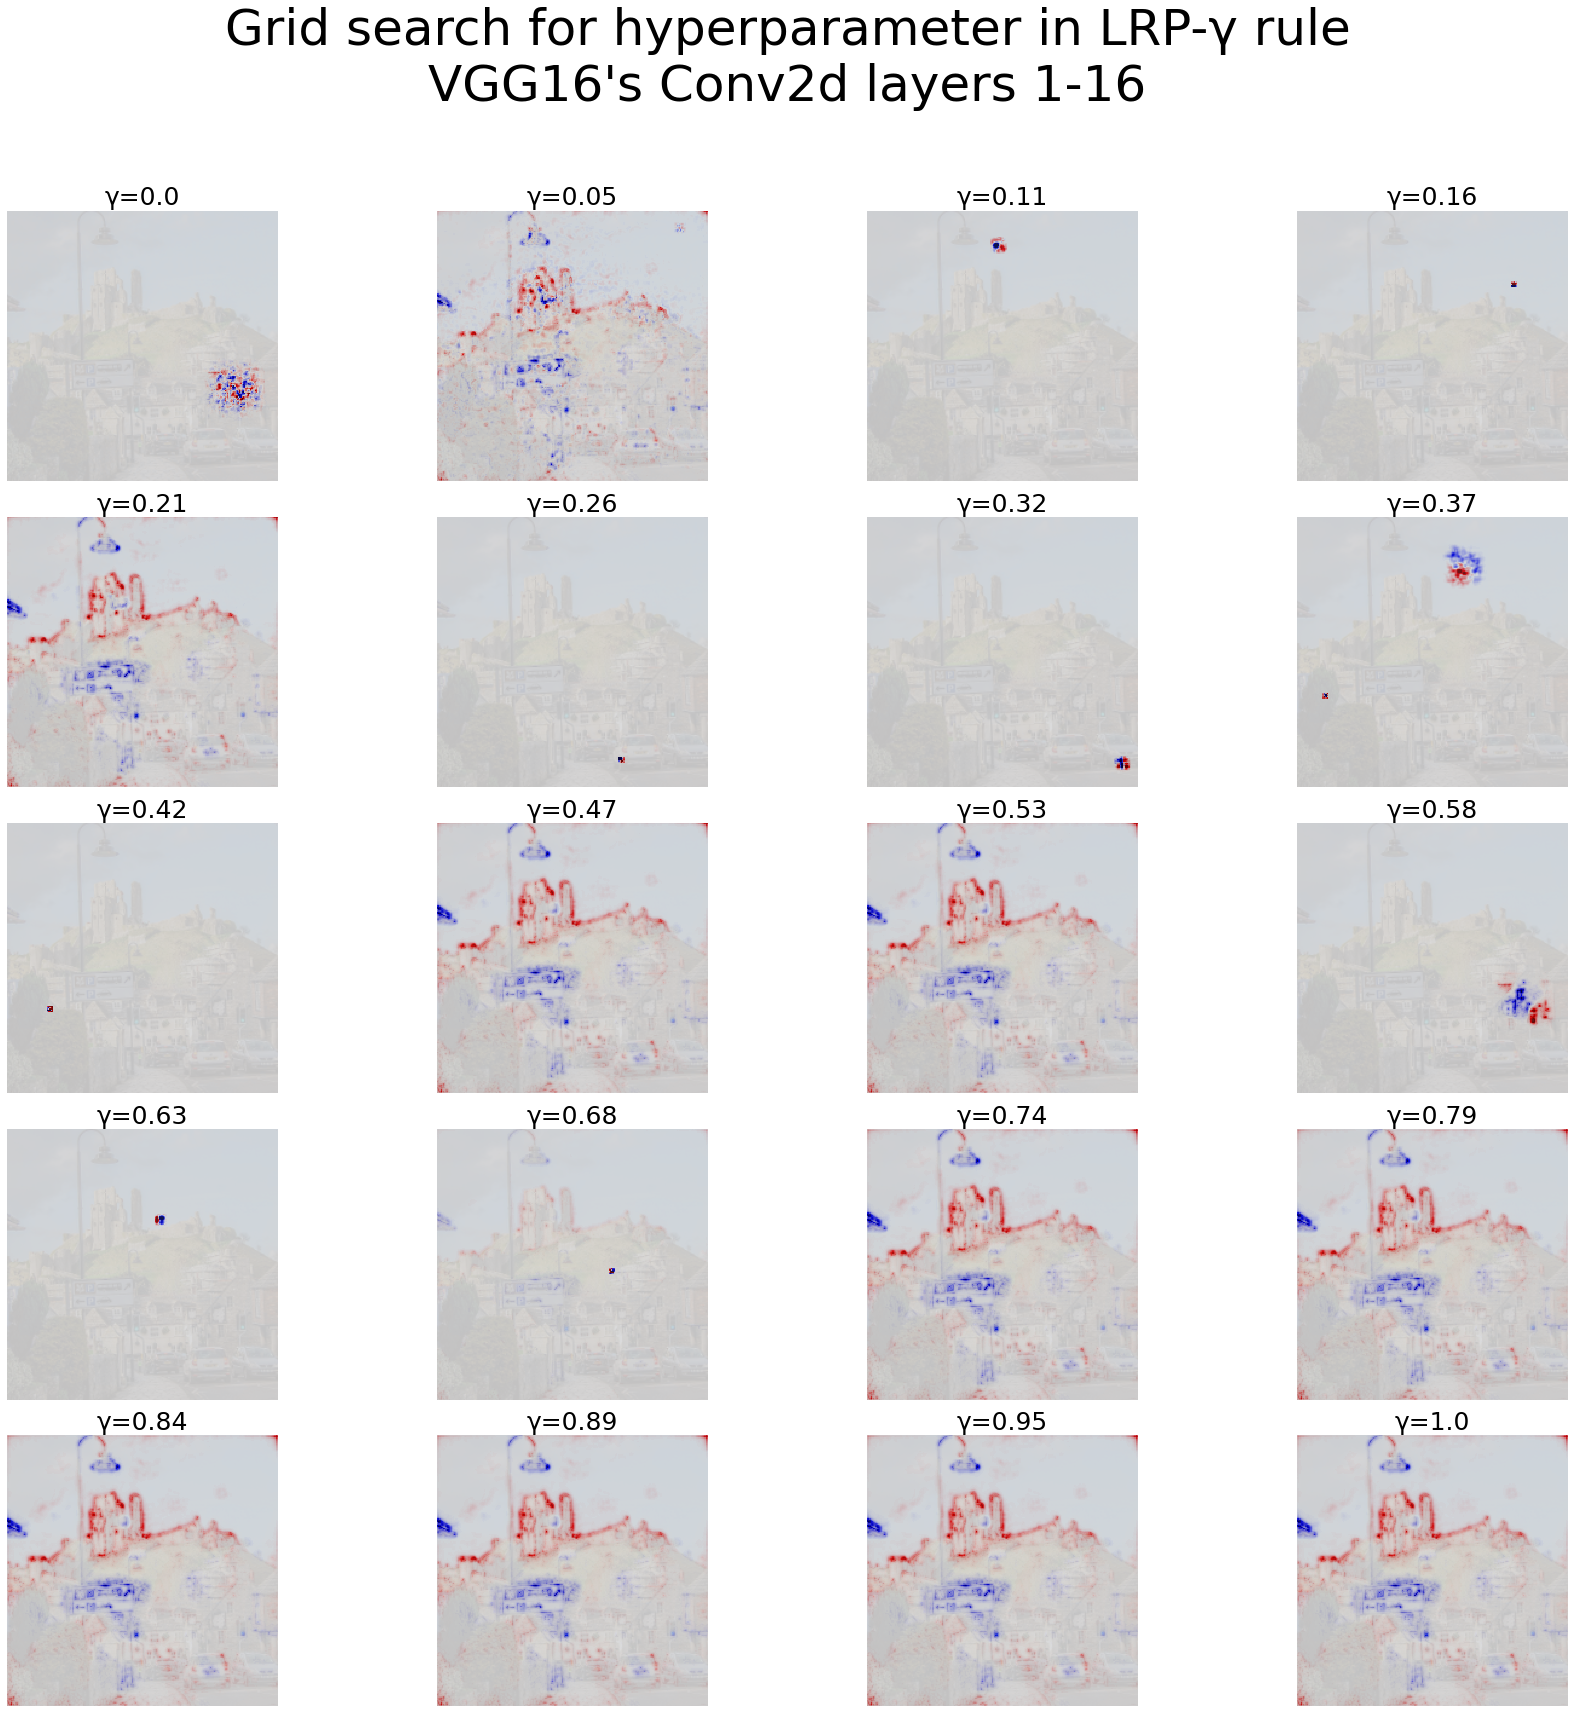

In [5]:
# Source: https://stackoverflow.com/a/46616645

import matplotlib.pyplot as plt
import lrp.image

# settings
ROWS, COLS = 5, 4  # array of sub-plots = len(gammas)
FIGSIZE = [25, 25] # figure size, inches
HEIGHT, WIDTH = 1, 1
FONTSIZE = FIGSIZE[0]*2
DPI = 150

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=ROWS, ncols=COLS, figsize=FIGSIZE)
fig.suptitle("Grid search for hyperparameter in LRP-γ rule\nVGG16's Conv2d layers 1-16", fontsize=FONTSIZE)

# plot simple raster image on each sub-plot
# axi is equivalent with ax[row_id][col_id]
for i, axi in enumerate(ax.flat):
    gamma, R = results[i]

    # heatmap of relevance scores
    lrp.image.plot_heatmap(relevance_scores=R[0].sum(dim=0).detach().numpy(), width=WIDTH, height=HEIGHT, fig=axi, show_plot=False, dpi=DPI)

    axi.imshow(img, alpha=0.1)

    axi.axis('off')

    axi.set_title(f'γ={round(gamma,2)}', fontsize=FONTSIZE*0.5)

# Add padding for better alignment of suptitle
# https://stackoverflow.com/a/45161551
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("high-res-gammas-lrp.png", dpi=200, facecolor="w")

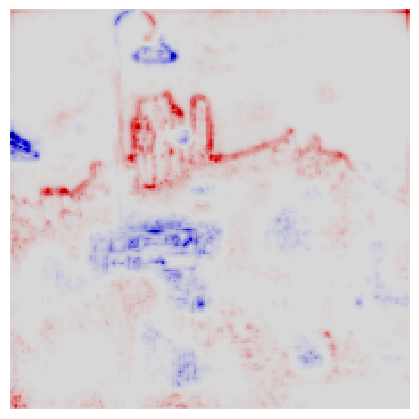

In [6]:
from lrp.core import LRP
LRP.heatmap(R)

# ToDo:

## Today

- Create a function for grid search plots
- Plot results with tensorboard

## Tomorrow

- Start writing thesis
- Prepare slides for meeting with Gregoire
  - Include a visual mapping of layers to rules
- Check reading list (slides on representation learning)

### Context 

Try to visualize network structure (perhaps using graphs). Saved links to reading list.

Found this repo which creates saliency maps for images:
- Find out which algorithm is used in [flashtorch](https://github.com/MisaOgura/flashtorch) to compute saliency maps.
  - Check ~/Downloads/flashtorch


---


## Nice-to-haves

- **Try seaborn for [heatmapping](https://seaborn.pydata.org/generated/seaborn.heatmap.html)**
- **Heuristic for `stabilize` function to scale epsilon according to dividend**
<!-- - Remove empty parameter for LrpZeroRule (set default value for `rule_kwargs` to `{}`) -->
- Implement debug function to print with toggle and remove print statements
- Use torchvision.transforms.Compose
- Integrate DataLoader into notebook
- Canonize models
